In [2]:
import sqlite3
import json
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage, 
    ToolMessage,
)
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from IPython.display import Image, display

ModuleNotFoundError: No module named 'langgraph.checkpoint.sqlite'

In [2]:
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [3]:
def run_graph(query:str, graph:StateGraph, thread_id:int):
    output = graph.invoke(
        config={"configurable":{"thread_id": thread_id}},
        input={"messages":[HumanMessage(query)]}
    )
    return output

**In-memory**

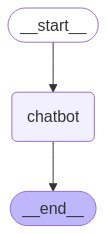

In [4]:
def chatbot(state: MessagesState):
    ai_message = llm.invoke(state["messages"])
    return {"messages": ai_message}


workflow = StateGraph(MessagesState)

workflow.add_node(chatbot)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

checkpointer = MemorySaver()
in_memory_graph = workflow.compile(checkpointer=checkpointer)

display(
    Image(
        in_memory_graph.get_graph().draw_mermaid_png()
    )
)

In [5]:
run_graph(
    query="Hi",
    graph=in_memory_graph, 
    thread_id="1"
)

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='80350509-d2a2-4649-9a93-28046d24335d'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'finish_reason': 'stop', 'logprobs': None}, id='run-2183fcd0-48a1-4514-a6af-1f89252c4489-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [6]:
list(
    in_memory_graph.get_state(
        config={"configurable":{"thread_id": "1"}}
    )
)

[{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='80350509-d2a2-4649-9a93-28046d24335d'),
   AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'finish_reason': 'stop', 'logprobs': None}, id='run-2183fcd0-48a1-4514-a6af-1f89252c4489-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]},
 (),
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1f00ca29-afbf-6cd0-80

**SQLite**

In [7]:
# For production, use something like Postgres
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

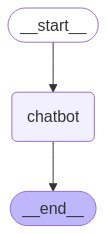

In [8]:
memory = SqliteSaver(conn)
external_memory_graph = workflow.compile(checkpointer=memory)

display(
    Image(
        external_memory_graph.get_graph().draw_mermaid_png()
    )
)

In [9]:
run_graph(
    query="What's a memory?",
    graph=external_memory_graph, 
    thread_id="2"
)

{'messages': [HumanMessage(content="What's a memory?", additional_kwargs={}, response_metadata={}, id='a3dc17f4-acb5-4552-9c8a-0c5d9cefaff2'),
  AIMessage(content='A memory can refer to several concepts, depending on the context:\n\n1. **Psychological Memory**: In psychology, memory is the mental capacity to encode, store, and retrieve information. It involves processes such as perception, attention, and recall, and can be categorized into different types, such as short-term memory, long-term memory, and working memory.\n\n2. **Biological Memory**: In neuroscience, memory refers to the mechanisms and structures in the brain that enable the storage and retrieval of information. This includes the roles of various brain regions, such as the hippocampus and amygdala, in forming and recalling memories.\n\n3. **Computer Memory**: In computing, memory refers to the components of a computer that store data temporarily or permanently. This includes RAM (Random Access Memory), which is used for 

In [10]:
list(
    external_memory_graph.get_state(
        config={"configurable":{"thread_id": "2"}}
    )
)

[{'messages': [HumanMessage(content="What's a memory?", additional_kwargs={}, response_metadata={}, id='a3dc17f4-acb5-4552-9c8a-0c5d9cefaff2'),
   AIMessage(content='A memory can refer to several concepts, depending on the context:\n\n1. **Psychological Memory**: In psychology, memory is the mental capacity to encode, store, and retrieve information. It involves processes such as perception, attention, and recall, and can be categorized into different types, such as short-term memory, long-term memory, and working memory.\n\n2. **Biological Memory**: In neuroscience, memory refers to the mechanisms and structures in the brain that enable the storage and retrieval of information. This includes the roles of various brain regions, such as the hippocampus and amygdala, in forming and recalling memories.\n\n3. **Computer Memory**: In computing, memory refers to the components of a computer that store data temporarily or permanently. This includes RAM (Random Access Memory), which is used fo

**Querying memory**

In [11]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [table_name[0] for table_name in cursor.fetchall()]
tables

['checkpoints', 'writes']

In [12]:
columns_map = []
results = []

for table in tables:
    cursor.execute(f"select * from {table}")
    results.append(cursor.fetchall())
    columns_map.append({table:[desc[0] for desc in cursor.description]})

In [13]:
columns_map

[{'checkpoints': ['thread_id',
   'checkpoint_ns',
   'checkpoint_id',
   'parent_checkpoint_id',
   'type',
   'checkpoint',
   'metadata']},
 {'writes': ['thread_id',
   'checkpoint_ns',
   'checkpoint_id',
   'task_id',
   'idx',
   'channel',
   'type',
   'value']}]

In [14]:
cursor.execute(f"select metadata from checkpoints")
metadata = cursor.fetchall()
metadata

[(b'{"source": "input", "writes": {"__start__": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "What\'s a memory?", "type": "human"}}]}}, "thread_id": "2", "step": -1, "parents": {}}',),
 (b'{"source": "loop", "writes": null, "thread_id": "2", "step": 0, "parents": {}}',),
 (b'{"source": "loop", "writes": {"chatbot": {"messages": {"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "AIMessage"], "kwargs": {"content": "A memory can refer to several concepts, depending on the context:\\n\\n1. **Psychological Memory**: In psychology, memory is the mental capacity to encode, store, and retrieve information. It involves processes such as perception, attention, and recall, and can be categorized into different types, such as short-term memory, long-term memory, and working memory.\\n\\n2. **Biological Memory**: In neuroscience, memory refers to the mechanisms and structures in the brain tha

In [15]:
steps = [json.loads(m[0]) for m in metadata]
steps

[{'source': 'input',
  'writes': {'__start__': {'messages': [{'lc': 1,
      'type': 'constructor',
      'id': ['langchain', 'schema', 'messages', 'HumanMessage'],
      'kwargs': {'content': "What's a memory?", 'type': 'human'}}]}},
  'thread_id': '2',
  'step': -1,
  'parents': {}},
 {'source': 'loop',
  'writes': None,
  'thread_id': '2',
  'step': 0,
  'parents': {}},
 {'source': 'loop',
  'writes': {'chatbot': {'messages': {'lc': 1,
     'type': 'constructor',
     'id': ['langchain', 'schema', 'messages', 'AIMessage'],
     'kwargs': {'content': 'A memory can refer to several concepts, depending on the context:\n\n1. **Psychological Memory**: In psychology, memory is the mental capacity to encode, store, and retrieve information. It involves processes such as perception, attention, and recall, and can be categorized into different types, such as short-term memory, long-term memory, and working memory.\n\n2. **Biological Memory**: In neuroscience, memory refers to the mechanisms 